# Task 2 Skeleton Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import re
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scipy.io as sio
plt.rcParams['figure.figsize'] = 10,10

import sklearn.datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Original Data

In [2]:
my_iris_data = sklearn.datasets.load_iris()
print ("my_iris_data.data.shape:",my_iris_data.data.shape)
print ("labels:",my_iris_data.target)

my_iris_data.data.shape: (150, 4)
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [3]:
X_train = np.concatenate((my_iris_data.data[10:50,:],my_iris_data.data[60:100,:], my_iris_data.data[110:150,:]))
X_train = np.concatenate((np.ones((X_train.shape[0],1)),X_train),axis=1) # Append bias term 1
y_train = np.concatenate((my_iris_data.target[10:50],my_iris_data.target[60:100], my_iris_data.target[110:150]))
print ("X_train.shape:", X_train.shape)
print ("y_train.shape:", y_train.shape)

X_test = np.concatenate((my_iris_data.data[40:50,:],my_iris_data.data[90:100,:], my_iris_data.data[140:150,:]))
X_test = np.concatenate((np.ones((X_test.shape[0],1)),X_test),axis=1) # Append bias term 1
y_test = np.concatenate((my_iris_data.target[40:50],my_iris_data.target[90:100], my_iris_data.target[140:150]))
print ("X_test.shape:", X_test.shape)
print ("y_test.shape:", y_test.shape)

X_train.shape: (120, 5)
y_train.shape: (120,)
X_test.shape: (30, 5)
y_test.shape: (30,)


## Preprocess the labels to get 3 datasets

In [4]:
y_train1 = np.copy(y_train); y_test1 = np.copy(y_test)
y_train2 = np.copy(y_train); y_test2 = np.copy(y_test)
y_train3 = np.copy(y_train); y_test3 = np.copy(y_test)

y_train1[y_train == 1] = -1
y_train1[y_train == 2] = -1
y_train1[y_train == 0] = 1
y_test1[y_test == 1] = -1
y_test1[y_test == 2] = -1
y_test1[y_test == 0] = 1

y_train2[y_train == 1] = 1
y_train2[y_train == 2] = -1
y_train2[y_train == 0] = -1
y_test2[y_test == 1] = 1
y_test2[y_test == 2] = -1
y_test2[y_test == 0] = -1

y_train3[y_train == 1] = -1
y_train3[y_train == 2] = 1
y_train3[y_train == 0] = -1
y_test3[y_test == 1] = -1
y_test3[y_test == 2] = 1
y_test3[y_test == 0] = -1

## Task2: Explicit SVM on iris

Original target function: 

$ L(\textbf{w}_1, \dots, \textbf{w}_K) = \frac{1}{2} \sum_{k=1}^{K}\left \| \textbf{w}_k \right \|^2 \nonumber + C \sum_{i} \sum_{k=1, k\ne y_i}^K max\big( 0, 1- (<\textbf{w}_{y_i}, \textbf{x}_i> - <\textbf{w}_k, \textbf{x}_i>) \big) \nonumber $

The gradient w.r.t $\textbf{w}$ of the target function:

$ L'(\textbf{w}_b) = \frac{dL(\textbf{w}_b)}{d \textbf{w}_b} = \textbf{w}_b + C \sum_{i} \sum_{k=1, k\ne y_i}^K\left\{\begin{matrix}
 \textbf{x}_i& \texttt{, if } (b=k) \wedge  (b\neq y_i) \wedge (<\textbf{w}_{y_i}, \textbf{x}_i>-<\textbf{w}_k, \textbf{x}_i> < 1)\\ 
 -\textbf{x}_i & \texttt{, if } (b \neq k) \wedge  (b= y_i) \wedge (<\textbf{w}_{y_i}, \textbf{x}_i>-<\textbf{w}_k, \textbf{x}_i> < 1) \\ 
 0 & \texttt{, otherwise} 
\end{matrix}\right.$

In [5]:
C=2 # the lambda
learning_rate = 0.0001 # the alpha
n_iter = 20000
iterations = []

In [6]:
def L_prime_w(X, Y, ws, C):
    K = ws.shape[1]  
    grad = np.zeros_like(ws)  
    for b in range(K):
        for i in range(X.shape[0]):
            for k in range(K):
                if Y[i] != k:
                    margin = np.dot(ws[:, Y[i]], X[i]) - np.dot(ws[:, k], X[i])
                    if margin < 1:
                        if b == Y[i]:
                            grad[:, b] -= C * X[i]
                        elif b == k:
                            grad[:, b] += C * X[i]
        grad[:, b] += ws[:, b]

    return grad


In [7]:
def L_w(X, Y, ws, C):
    ########### YOUR CODE HERE ###########
    K = ws.shape[1]
    loss = 0
    for i in range(X.shape[0]):
        for k in range(K):
            if k != Y[i]:
                loss += max(0, 1 - (np.dot(ws[:, Y[i]], X[i]) - np.dot(ws[:, k], X[i])))
    
    
    ret =  0.5 * np.sum(ws ** 2) + C * loss
    return ret


### (Warning! The next cell takes time to finish descending!)

In [8]:
w = np.zeros((X_train.shape[1], 3))

# We will keep track of training loss over iterations
iterations = [0]
L_w_list = [L_w(X_train, y_train, w,C)]
for i in range(n_iter):
    
    gradient = L_prime_w(X_train, y_train, w, C)  
    # print(gradient)
    w_new = w - learning_rate * gradient
    iterations.append(i+1)
    L_w_list.append(L_w(X_train, y_train, w_new, C)) 

    if np.linalg.norm(w_new - w, ord=1) < 0.001:
        print(f"Gradient descent has converged after {i} iterations.")
        break
    
    # if i % 1000 == 0:
    #     print(i, np.linalg.norm(w_new - w, ord=1), L_w_list[-1])
    w = w_new
    
print ("w vector: \n" + str(w))

Gradient descent has converged after 2136 iterations.
w vector: 
[[ 0.24049589  0.61570382 -0.85619971]
 [ 0.54962307  0.34553133 -0.8951544 ]
 [ 0.94533576  0.151773   -1.09710876]
 [-1.40369287 -0.18671239  1.59040526]
 [-0.77774176 -0.88098094  1.6587227 ]]


### Results on Training set

In [9]:
prediction = np.argmax(np.dot(X_train, w),axis=1)
training_accuracy = (prediction - y_train == 0)

print ("The training accuracy:", np.sum(training_accuracy)*1.0/X_train.shape[0]*100, "%.")

The training accuracy: 97.5 %.


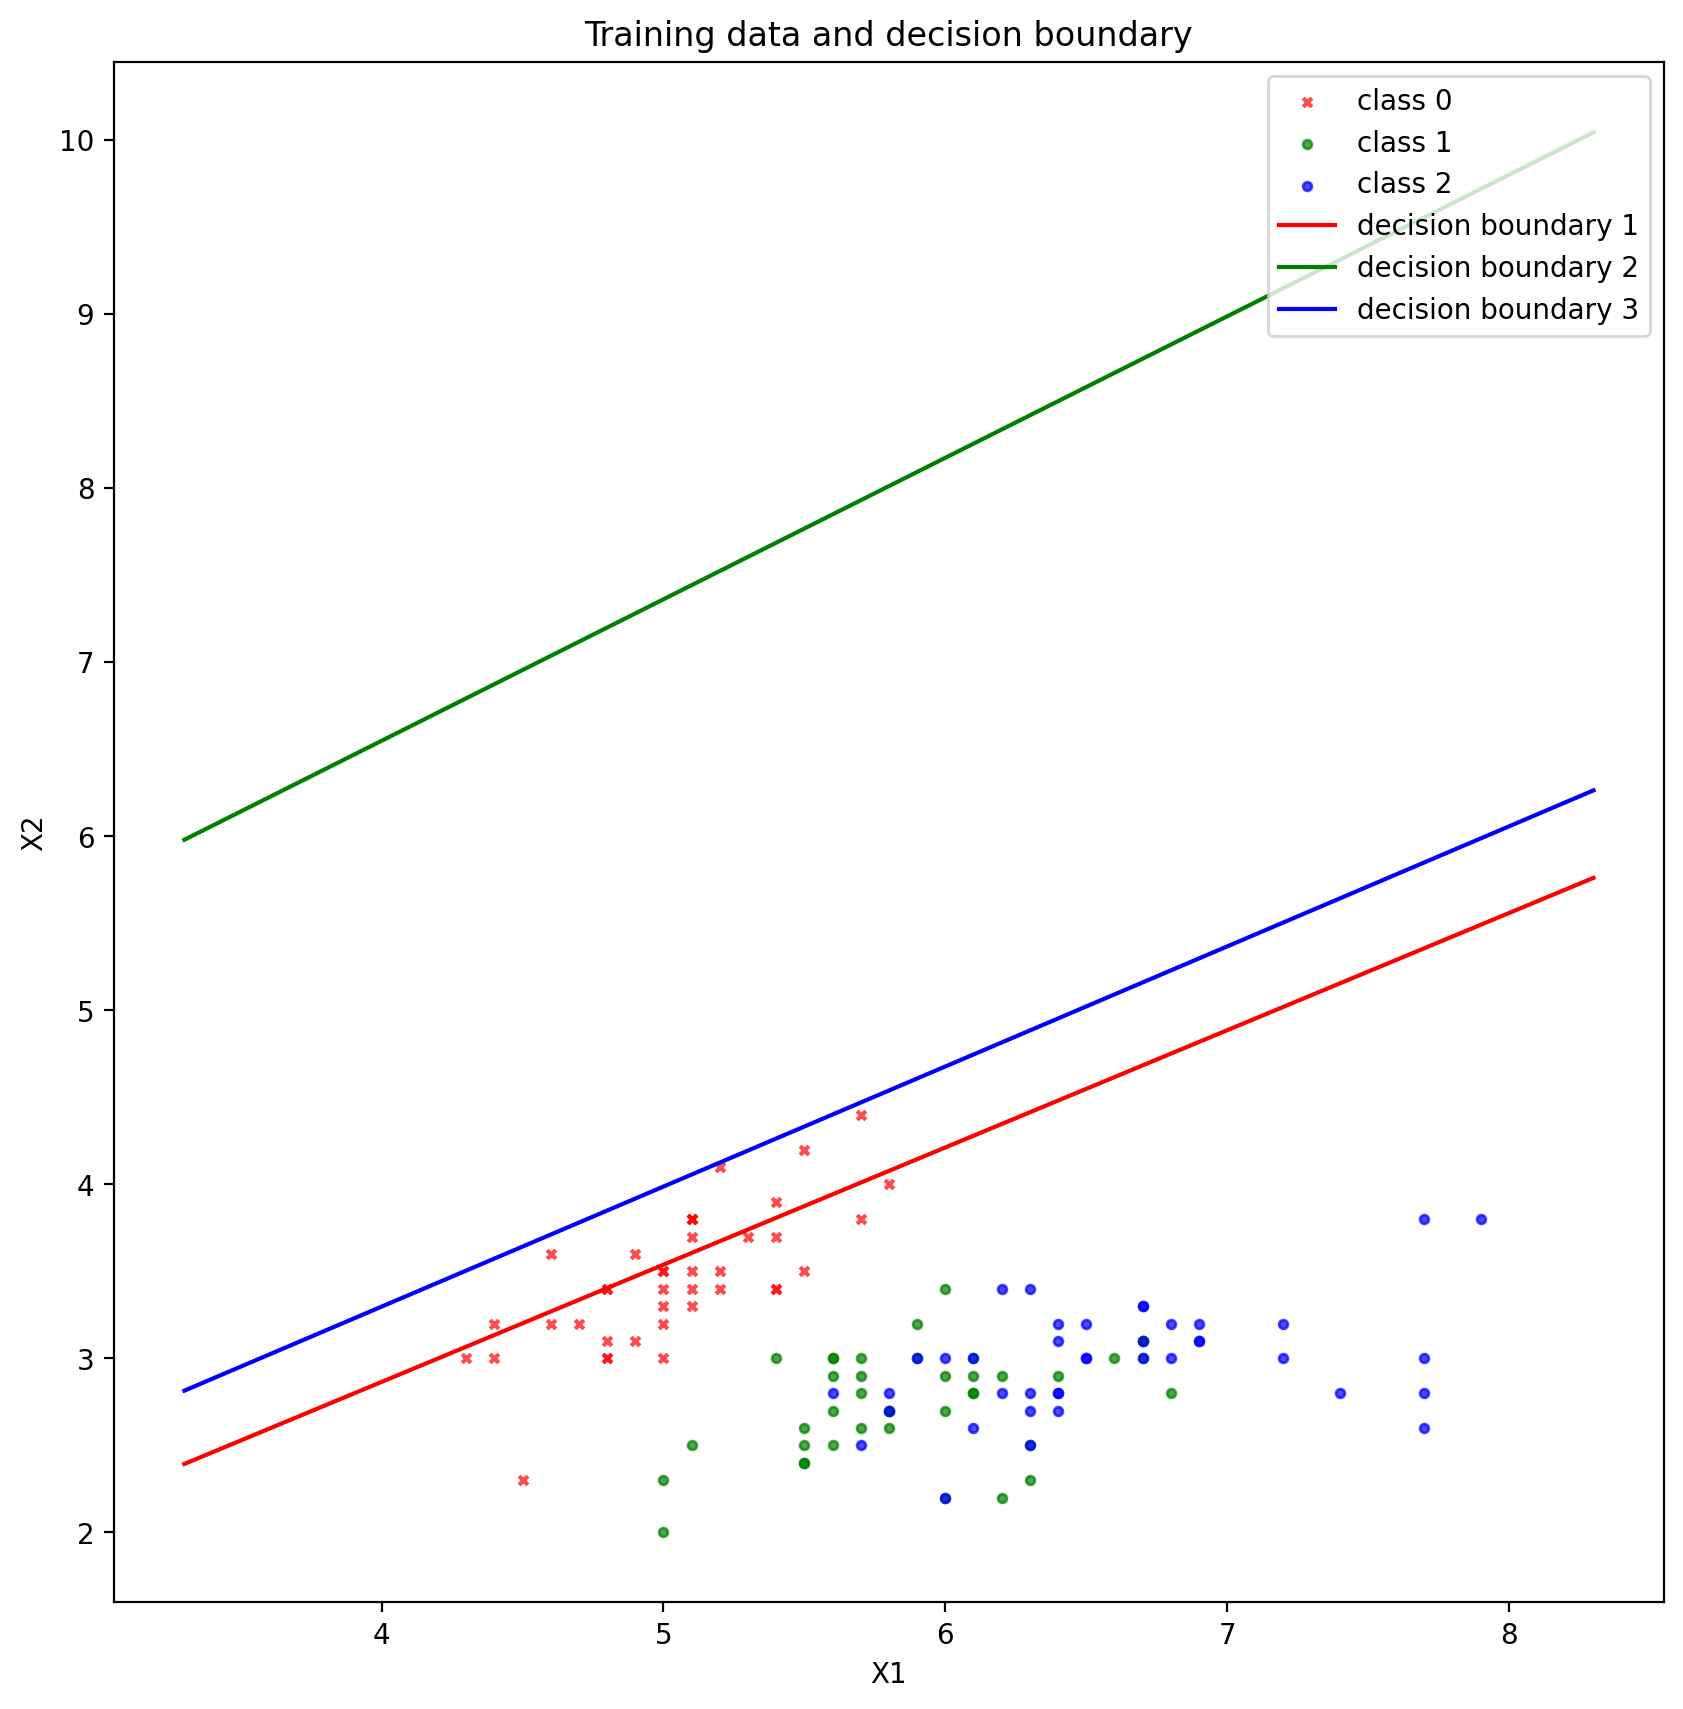

In [10]:
x1 = 1; x2 = 2
x = np.arange(np.min(X_train[:,x1])-1,np.max(X_train[:,x1])+1,1.0)
y1 = (-w[0][0]-w[2][0]*x)/w[3][0]
y2 = (-w[0][1]-w[2][1]*x)/w[3][1]
y3 = (-w[0][2]-w[2][2]*x)/w[3][2]

plt.scatter(X_train[y_train==0, x1], X_train[y_train==0, x2], marker='x', color='r', alpha=0.7, s=10, label='class 0')
plt.scatter(X_train[y_train==1, x1], X_train[y_train==1, x2], marker='o', color='g', alpha=0.7, s=10, label='class 1')
plt.scatter(X_train[y_train==2, x1], X_train[y_train==2, x2], marker='o', color='b', alpha=0.7, s=10, label='class 2')

plt.xlabel('X1')
plt.ylabel('X2')
plt.plot(x,y1, color='r', label='decision boundary 1')
plt.plot(x,y2, color='g', label='decision boundary 2')
plt.plot(x,y3, color='b', label='decision boundary 3')
plt.title('Training data and decision boundary')

plt.legend(loc='upper right', fontsize=10)

### Results on Test set

In [11]:
#prediction = 2 * (np.dot(X_test, w) >= 0) - 1
#prediction = sigmoid(np.dot(X_test, w)) >= 0.5
prediction = np.argmax(np.dot(X_test, w), axis=1)

testing_accuracy = np.sum(prediction == y_test)*1.0/X_test.shape[0]
print ("The test accuracy: ", testing_accuracy*100, "%.")

The test accuracy:  100.0 %.


Gradient descent has converged after 1418 iterations.
The optimal w value for 0.5 is [[ 0.13683175  0.22141095 -0.3582427 ]
 [ 0.302219    0.30850574 -0.61072474]
 [ 0.66209984 -0.07204984 -0.59004999]
 [-0.90310932 -0.13419829  1.03730761]
 [-0.44467636 -0.43764858  0.88232493]]
The training accuracy: 96.66666666666667 %.
The test accuracy:  100.0 %.
Gradient descent has converged after 2136 iterations.
The optimal w value for 2.0 is [[ 0.24049589  0.61570382 -0.85619971]
 [ 0.54962307  0.34553133 -0.8951544 ]
 [ 0.94533576  0.151773   -1.09710876]
 [-1.40369287 -0.18671239  1.59040526]
 [-0.77774176 -0.88098094  1.6587227 ]]
The training accuracy: 97.5 %.
The test accuracy:  100.0 %.
The optimal w value for 5.0 is [[ 0.32565877  2.0520867  -2.37774548]
 [ 0.76642075  0.05935994 -0.8257807 ]
 [ 1.09661822  0.34949159 -1.44610981]
 [-1.71943464 -0.10492715  1.82436179]
 [-1.08655626 -1.27722908  2.36378534]]
The training accuracy: 95.83333333333334 %.
The test accuracy:  100.0 %.
The o

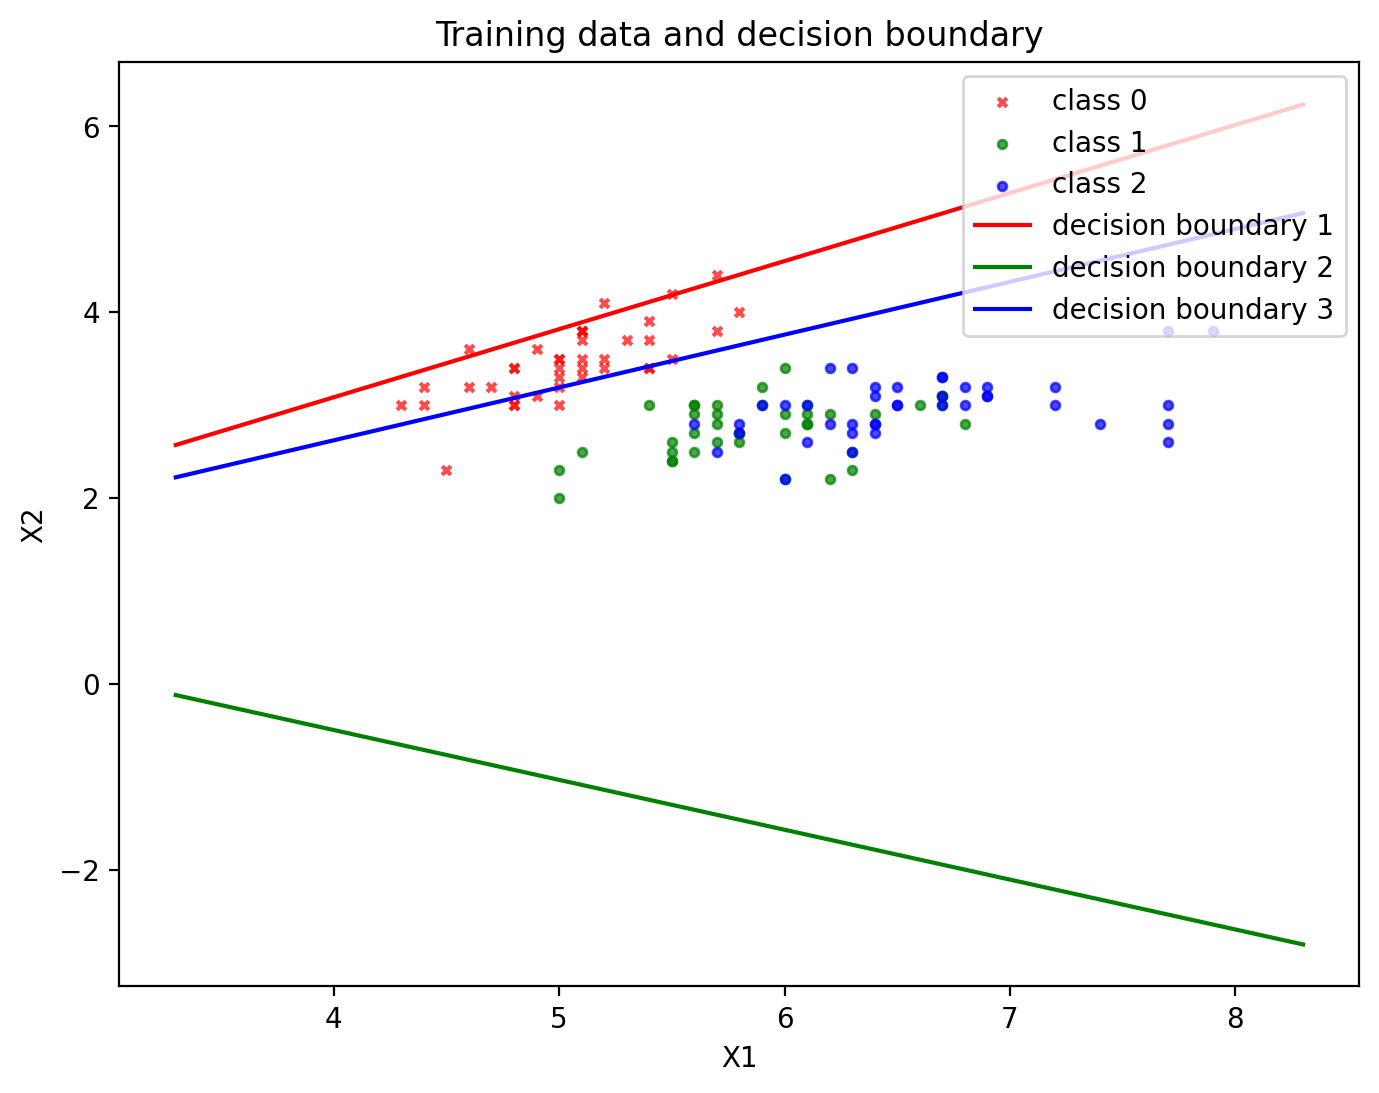

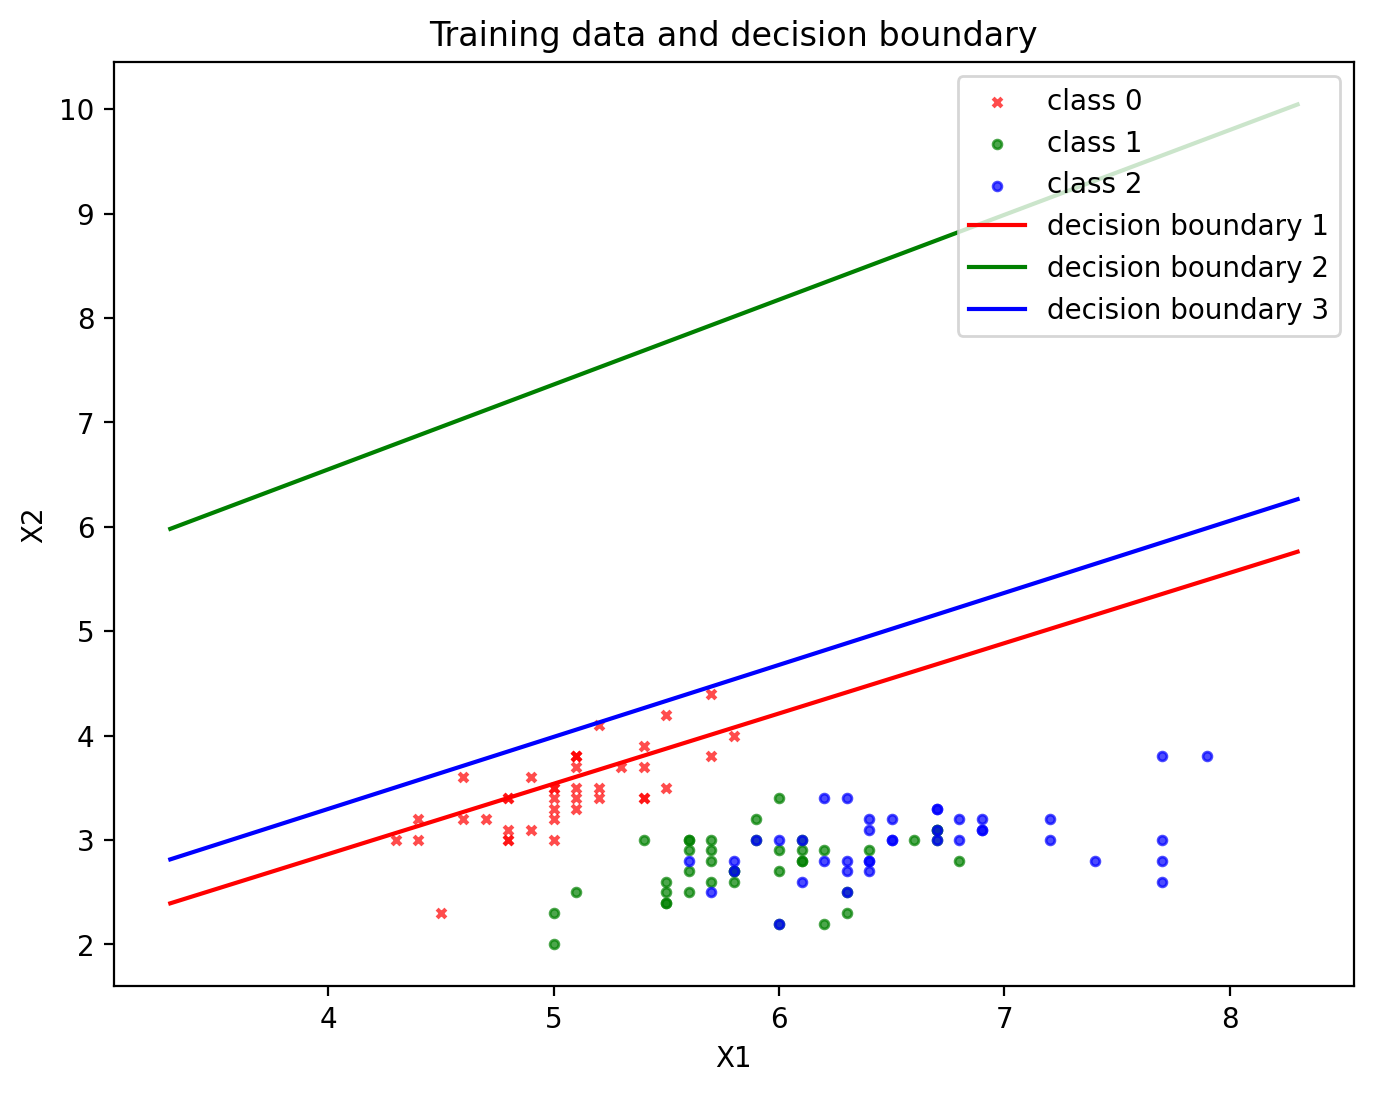

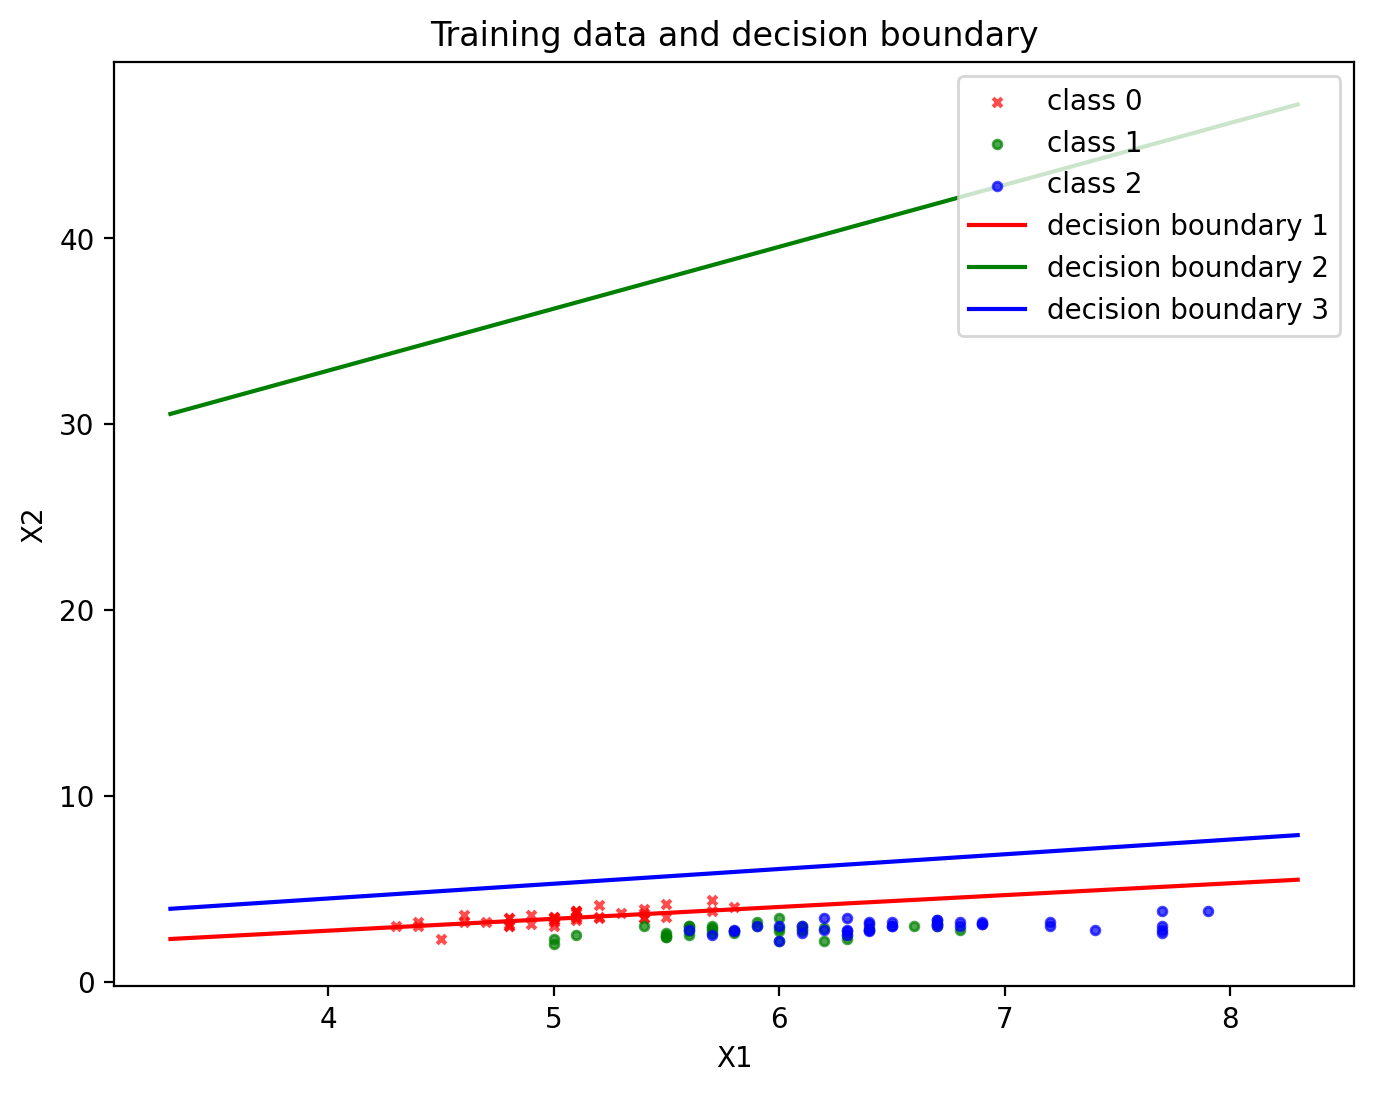

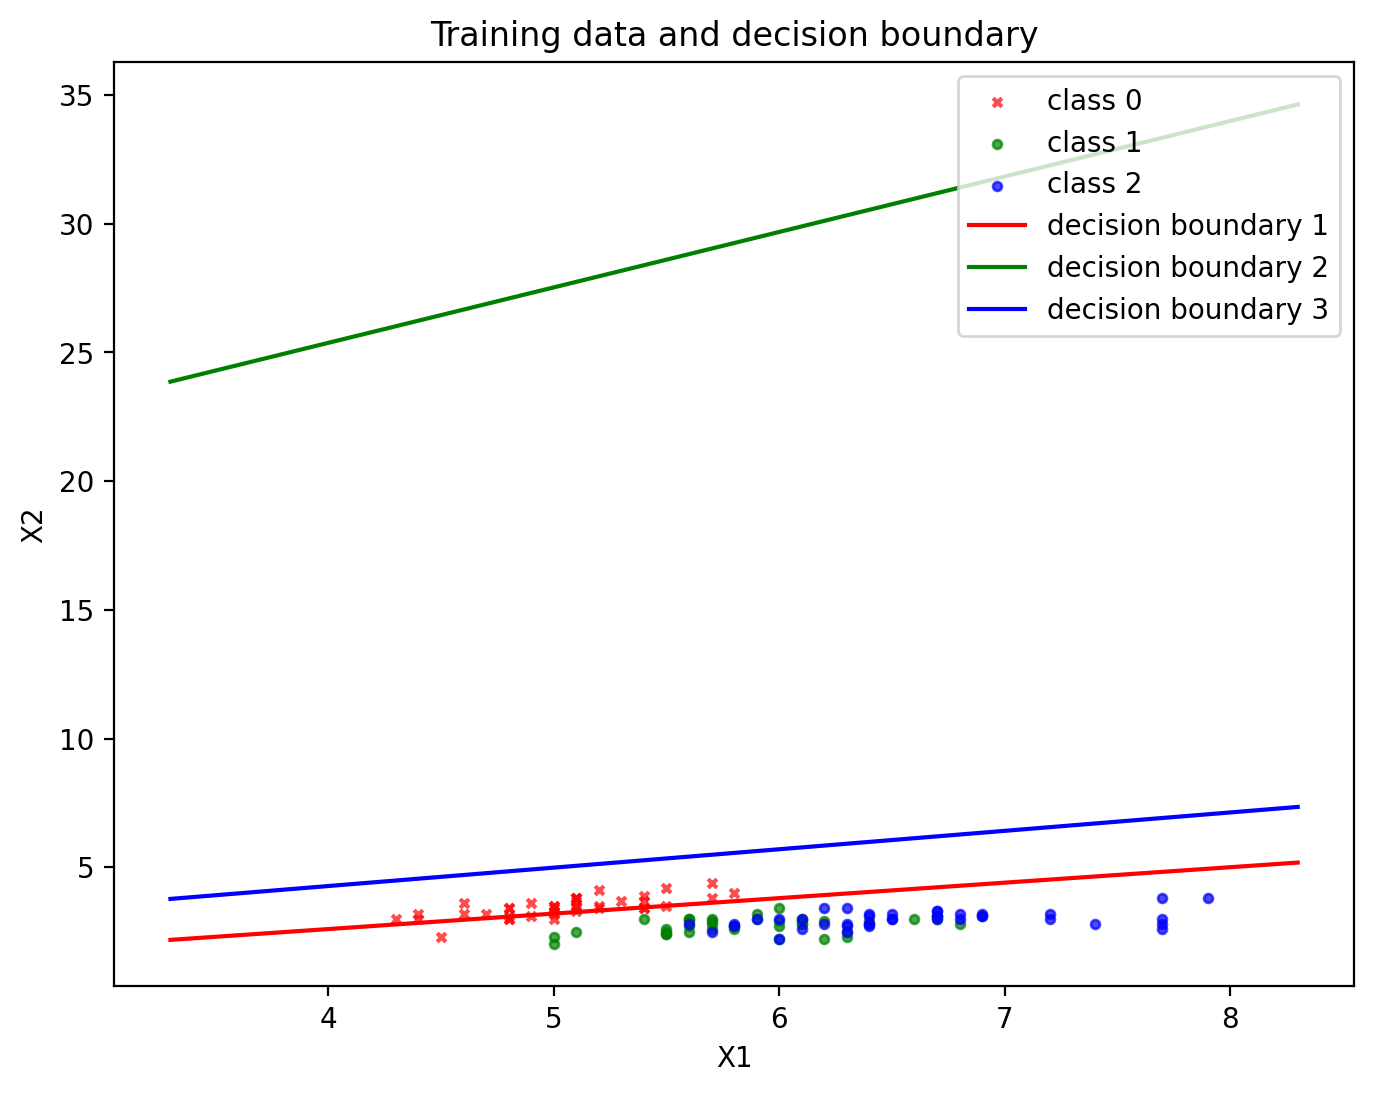

In [12]:
C_values = [0.5, 2.0, 5.0, 10.0]

for C in C_values:
    w = np.zeros((X_train.shape[1], 3))

    # We will keep track of training loss over iterations
    iterations = [0]
    #L_w_list = [L_w(X_train, y_train, w,C)]
    for i in range(n_iter):
    
        gradient = L_prime_w(X_train, y_train, w, C)  
        #print(gradient)
        w_new = w - learning_rate * gradient
        iterations.append(i+1)
        #L_w_list.append(L_w(X_train, y_train, w_new, C)) 

        if np.linalg.norm(w_new - w, ord=1) < 0.001:
            print(f"Gradient descent has converged after {i} iterations.")
            break
        # if i % 1000 == 0:
        #     print(i, np.linalg.norm(w_new - w, ord=1), L_w_list[-1])
        w = w_new
    print('The optimal w value for {} is {}'.format(C,w))
    prediction = np.argmax(np.dot(X_train, w),axis=1)
    training_accuracy = (prediction - y_train == 0)
    print ("The training accuracy:", np.sum(training_accuracy)*1.0/X_train.shape[0]*100, "%.")
    prediction = np.argmax(np.dot(X_test, w), axis=1)

    testing_accuracy = np.sum(prediction == y_test)*1.0/X_test.shape[0]
    print ("The test accuracy: ", testing_accuracy*100, "%.")
    plt.figure(figsize=(8, 6)) 
    x1 = 1; x2 = 2
    x = np.arange(np.min(X_train[:,1])-1,np.max(X_train[:,x1])+1,1.0)
    y1 = (-w[0][0]-w[2][0]*x)/w[3][0]
    y2 = (-w[0][1]-w[2][1]*x)/w[3][1]
    y3 = (-w[0][2]-w[2][2]*x)/w[3][2]

    plt.scatter(X_train[y_train==0, x1], X_train[y_train==0, x2], marker='x', color='r', alpha=0.7, s=10, label='class 0')
    plt.scatter(X_train[y_train==1, x1], X_train[y_train==1, x2], marker='o', color='g', alpha=0.7, s=10, label='class 1')
    plt.scatter(X_train[y_train==2, x1], X_train[y_train==2, x2], marker='o', color='b', alpha=0.7, s=10, label='class 2')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.plot(x,y1, color='r', label='decision boundary 1')
    plt.plot(x,y2, color='g', label='decision boundary 2')
    plt.plot(x,y3, color='b', label='decision boundary 3')
    plt.title('Training data and decision boundary')

    plt.legend(loc='upper right', fontsize=10)



In [ ]:
w = np.zeros((X_train.shape[1], 3))

# We will keep track of training loss over iterations
iterations = [0]
L_w_list = [L_w(X_train, y_train, w,2.0)]
for i in range(n_iter):
    
    gradient = L_prime_w(X_train, y_train, w, 2.0)  
    # print(gradient)
    w_new = w - learning_rate * gradient
    iterations.append(i+1)
    L_w_list.append(L_w(X_train, y_train, w_new, 2.0)) 

    # if np.linalg.norm(w_new - w, ord=1) < 0.001:
    #     print(f"Gradient descent has converged after {i} iterations.")
    #     break
    
    # if i % 1000 == 0:
    #     print(i, np.linalg.norm(w_new - w, ord=1), L_w_list[-1])
    w = w_new
print('The optimal w value is {}'.format(w))

The best C value is 2.0


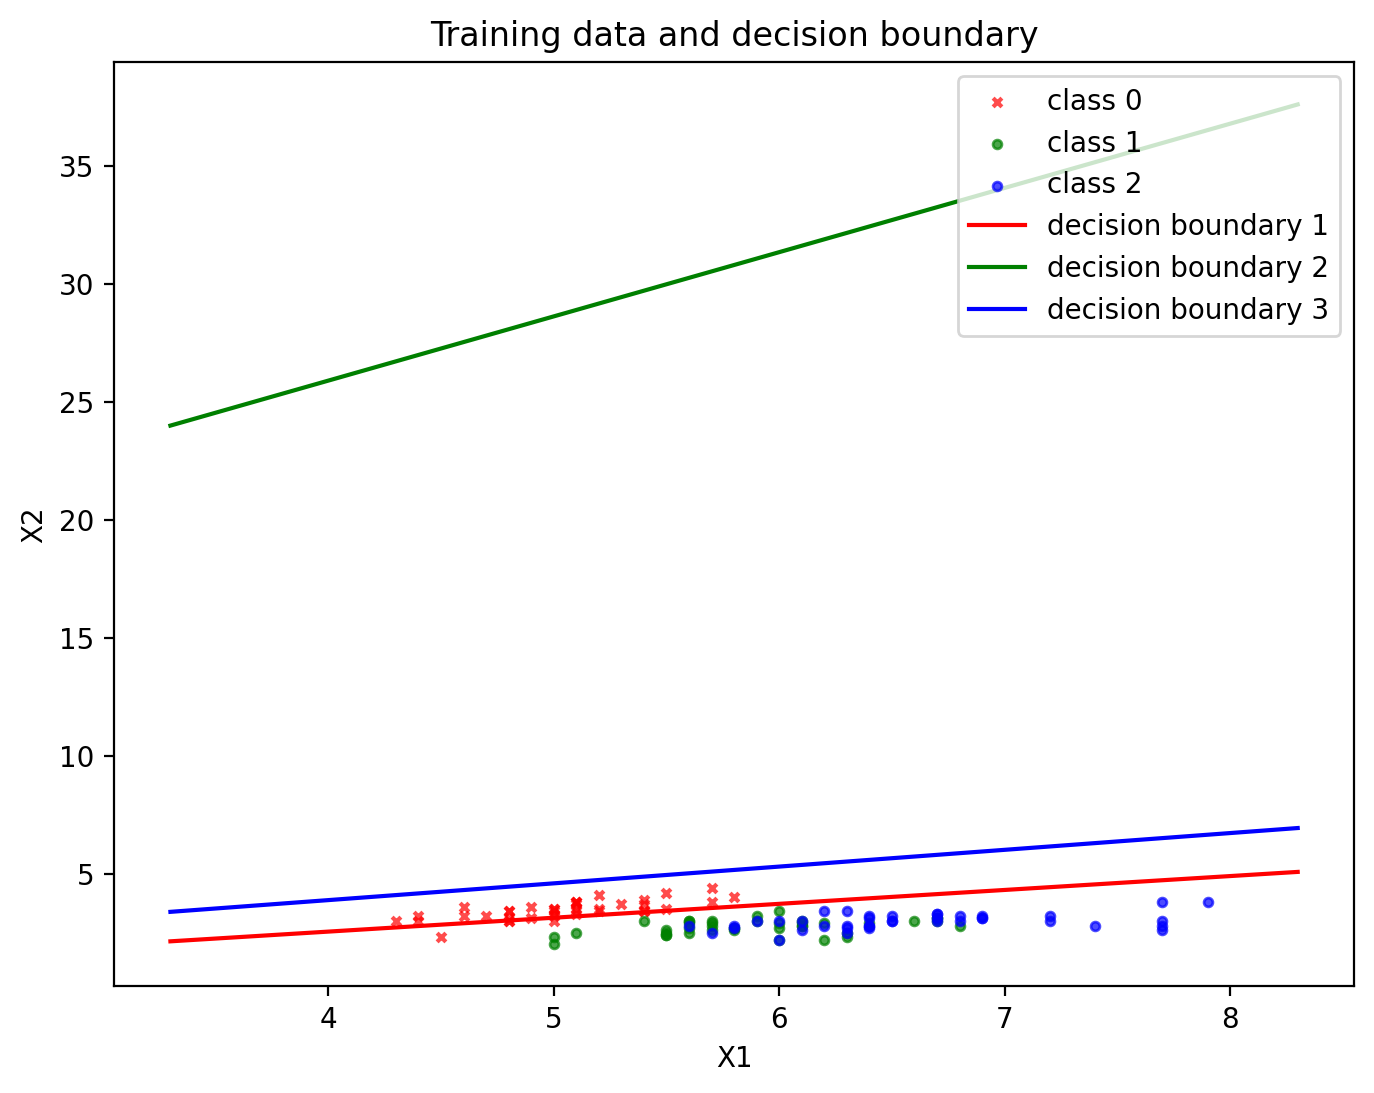

In [14]:
plt.figure(figsize=(8, 6)) 
x1 = 1; x2 = 2
x = np.arange(np.min(X_train[:,1])-1,np.max(X_train[:,x1])+1,1.0)
y1 = (-w[0][0]-w[2][0]*x)/w[3][0]
y2 = (-w[0][1]-w[2][1]*x)/w[3][1]
y3 = (-w[0][2]-w[2][2]*x)/w[3][2]

plt.scatter(X_train[y_train==0, x1], X_train[y_train==0, x2], marker='x', color='r', alpha=0.7, s=10, label='class 0')
plt.scatter(X_train[y_train==1, x1], X_train[y_train==1, x2], marker='o', color='g', alpha=0.7, s=10, label='class 1')
plt.scatter(X_train[y_train==2, x1], X_train[y_train==2, x2], marker='o', color='b', alpha=0.7, s=10, label='class 2')

plt.xlabel('X1')
plt.ylabel('X2')
plt.plot(x,y1, color='r', label='decision boundary 1')
plt.plot(x,y2, color='g', label='decision boundary 2')
plt.plot(x,y3, color='b', label='decision boundary 3')
plt.title('Training data and decision boundary')

plt.legend(loc='upper right', fontsize=10)
